# Stanford Stats 191

## Introduction

This is a re-creation of the Stanford Stats 191 course, using Python eco-system tools, instead of R. This is lecture "Diagnostics for simple linear regression" ( see https://web.stanford.edu/class/stats191/notebooks/Simple_diagnostics.html)

We look at how we can assert that a linear model is appropriate (or not, as the case may be)


## Initial Notebook Setup

```watermark``` documents the Python and package environment, ```black``` is my chosen Python formatter

In [257]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [258]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [259]:
%matplotlib inline

All imports go here.

In [260]:
import pandas as pd
import numpy as np
import seaborn as sn

import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
import statsmodels.api as sm

from statsmodels.sandbox.regression.predstd import (
    wls_prediction_std,
)

from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_goldfeldquandt


import os

----
## Create Data

To illustrate the basic concepts of linear regression, we create a dataset, where y depends upon x, and has added Gaussion noise.

In [261]:
x = np.linspace(0, 20, 21)
y = 0.5 * x + 1 + np.random.normal(0, 1, 21)

df_dict = {'x': x, 'y': y}
data = pd.DataFrame(df_dict)

----
## Analyse Data
We perform a Ordinary Least Squares regression to get the line of best fit

In [262]:
res = ols('y ~ x', data=data).fit()

Plot the data.  We choose to use high-level matplotlib methods, at the expense of some plotting elegance

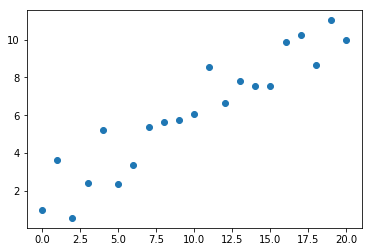

In [263]:
_ = plt.plot(x, y, 'o')

Plot the data and line of best fit

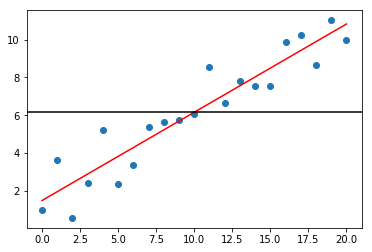

In [264]:
_ = plt.plot(x, y, 'o')
_ = plt.plot(x, res.predict(), 'r-')
_ = plt.axhline(y.mean(), color='k')

The graphs below illustrate the definitions of various sums of squares; ```SST``` is Sun Of Squares Total (deviation from the mean of the actual data), ```SSE``` is the Sum of Squares of Errors (deviation from the actuals of the predictions), ```SSR``` is the Sum of Squares of the Residuals (deviation from the mean of the predictions)

$$ SST = \sum_{i=1}^{n}(Y_i-\bar{Y})^2
\\
SSE = \sum_{i=1}^{n} (Y_i -\hat{Y_i})^{2}
\\ 
SSR = \sum_{i=1}^n (\bar{Y}-\hat{Y_i})^2 $$

Text(0.5, 1.0, 'Total Sum of Squares')

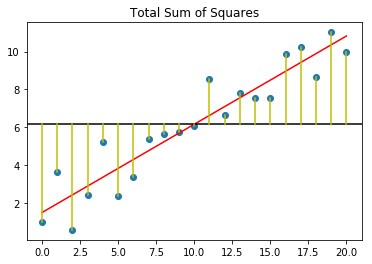

In [265]:
_ = plt.plot(x, y, 'o')
_ = plt.plot(x, res.predict(), 'r-')
_ = plt.axhline(y.mean(), color='k')
for i in range(len(x)):
    plt.plot([x[i], x[i]], [y[i], y.mean()], 'y-')
# end for
plt.title('Total Sum of Squares')

Text(0.5, 1.0, 'Error Sum of Squares')

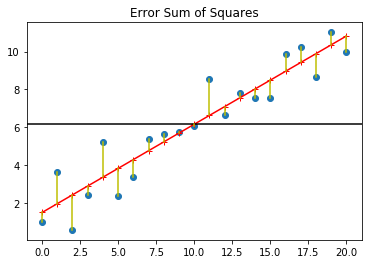

In [266]:
_ = plt.plot(x, y, 'o')
_ = plt.plot(x, res.predict(), 'r-')
_ = plt.plot(x, res.predict(), 'r+')
_ = plt.axhline(y.mean(), color='k')
for i in range(len(x)):
    plt.plot([x[i], x[i]], [y[i], res.predict()[i]], 'y-')
# end for
plt.title('Error Sum of Squares')

Text(0.5, 1.0, 'Regression Sum of Squares')

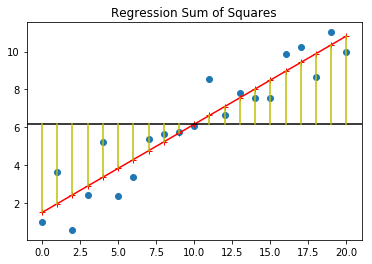

In [267]:
_ = plt.plot(x, y, 'o')
_ = plt.plot(x, res.predict(), 'r-')
_ = plt.plot(x, res.predict(), 'r+')
_ = plt.axhline(y.mean(), color='k')
for i in range(len(x)):
    plt.plot(
        [x[i], x[i]], [y.mean(), res.predict()[i]], 'y-'
    )
# end for
plt.title('Regression Sum of Squares')

----
## Read Data

We now read a more realistic dataset, relating wage level to education

In [268]:
data = pd.read_csv('../data/wage.csv')

### Explore Data

In [269]:
data.head()

,education,logwage
0,16.750000,2.845000
1,15.000000,2.446667
2,10.000000,1.560000
3,12.666667,2.099167
4,15.000000,2.490000


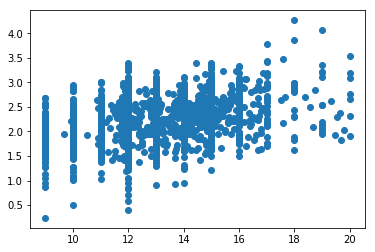

In [270]:
_ = plt.plot(data['education'], data['logwage'], 'o')

In order to more clearly see where the data points lie, we add "jitter" so they don't overlap as much.  We also adjust ```alpha```

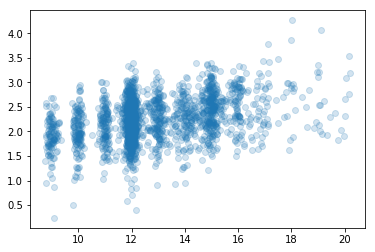

In [271]:
jitter = 0.1
_ = plt.plot(
    data['education']
    + np.random.normal(0, 1, len(data['education']))
    * jitter,
    data['logwage'],
    'o',
    alpha=0.2,
)

### Perform OLS Linear Best Fit

In [272]:
res = ols('logwage ~ education', data=data).fit()

Show the line of best fit

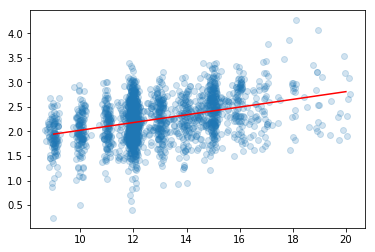

In [273]:
jitter = 0.1
_ = plt.plot(
    data['education']
    + np.random.normal(0, 1, len(data['education']))
    * jitter,
    data['logwage'],
    'o',
    alpha=0.2,
)
data['predict'] = res.predict()
data_std = data.sort_values(by='education')
_ = plt.plot(
    data_std['education'], data_std['predict'], 'r-'
)

Compute the Sums of Squares defined above.  We use ```np.ones()``` to create vectors of constants

In [274]:
n_data = len(data['education'])

SSE = sum(res.resid * res.resid)

sst_array = (
    data['logwage']
    - np.ones(n_data) * data['logwage'].mean()
)
SST = sum(sst_array * sst_array)
sse_array = (
    np.ones(n_data) * data['logwage'].mean() - res.predict()
)
SSR = sum(sse_array * sse_array)

In [275]:
SST, SSE + SSR

(410.2148277475003, 410.21482774750143)

Compute the F statistic

In [276]:
F = (SSR / 1) / (SSE / res.df_resid)

In [277]:
F

340.0296918700766

Check this manually calculated value with the OLS summary

In [278]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logwage   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     340.0
Date:                Thu, 19 Mar 2020   Prob (F-statistic):           1.15e-70
Time:                        20:15:35   Log-Likelihood:                -1114.3
No. Observations:                2178   AIC:                             2233.
Df Residuals:                    2176   BIC:                             2244.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2392      0.055     22.541      0.000       1.131       1.347
education      0.0786      0.004     18.440      0.000       0.070       0.087
==============================================================================
Omnibus:                       46.662   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.725
Skew:                          -0.269   Prob(JB):                     1.07e-13
Kurtosis:                       3.606   Cond. No.                         82.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We get the interval that contains 90% of the F distribution function, given the degrees of freedom we have

In [279]:
stats.f.interval(0.90, 1, res.df_resid)

(0.003933047182904572, 3.8457358464718414)

We clearly have a F statistic much larger than this, 
so we would reject the Null Hypothesis that there is no linear dependence of ```logwages``` on ```education```.

----
## When a Linear Model is Wrong

The Anscombe quartet is a famous quartet of datasets, all having the same descriptive numerical values (mean, etc), but wildly different shapes when plotted.  We will use the dataset that is a quadratic.

In [280]:
data = pd.read_csv('../data/anscombe.csv')

In [281]:
data.head()

,x1,y1,x2,y2,x3,y3,x4,y4
0,10,8.04,10,9.14,10,7.46,8,6.58
1,8,6.95,8,8.14,8,6.77,8,5.76
2,13,7.58,13,8.74,13,12.74,8,7.71
3,9,8.81,9,8.77,9,7.11,8,8.84
4,11,8.33,11,9.26,11,7.81,8,8.47


Add some Gaussian noise

In [282]:
data['y2'] = (
    data['y2']
    + np.random.normal(0, 1, len(data['y2'])) * 0.45
)

Display the dataset

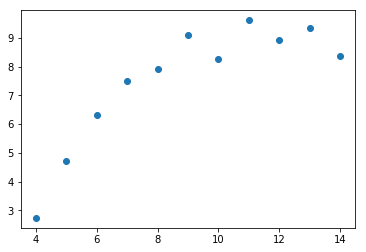

In [283]:
_ = plt.plot(data['x2'], data['y2'], 'o')

### Fit a Linear Model
 We get the best OLS line, and display it

In [284]:
res = ols('y2 ~ x2', data=data).fit()

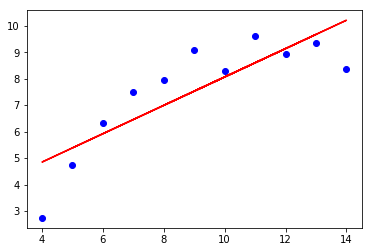

In [285]:
_ = plt.plot(data['x2'], data['y2'], 'bo')
_ = plt.plot(data['x2'], res.predict(), 'r-')

When we plot the residuals, we can see that they are apparently not distributed at random (negative at the end, positive in the middle)

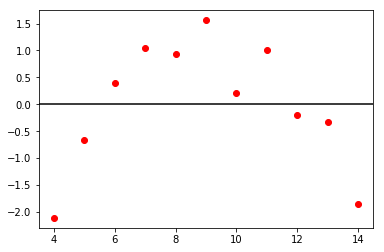

In [286]:
_ = plt.plot(data['x2'], res.resid, 'ro')
_ = plt.axhline(0, color='black')

### Fit a Quadratic Model

We add a term ```X^2``` to our linear  model

In [287]:
data['x2sq'] = data['x2'] * data['x2']

data_std = data.sort_values(by='x2')

In [288]:
res2 = ols('y2 ~ x2 + x2sq', data=data_std).fit()

The fit is clearly much better, and the residuals look to be more randomly distributed

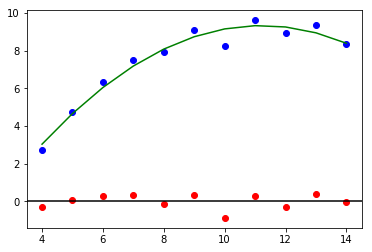

In [289]:
_ = plt.plot(data['x2'], data['y2'], 'bo')
_ = plt.plot(data_std['x2'], res2.resid, 'ro')
_ = plt.plot(data_std['x2'], res2.predict(), 'g-')
_ = plt.axhline(0, color='black')

Just plotting the residuals, we see they are smaller than those of the the pure linear model

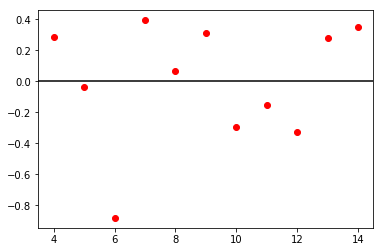

In [290]:
_ = plt.plot(data['x2'], res2.resid, 'ro')
_ = plt.axhline(0, color='black')

----
## QQ Plots

One technique for finding a model that is bad is to look at the QQ Plots for the residuals of eac h OLS fit (linear and quadratic).  This is a test for normality; in this case, the difference is very subtle, and could not be used to reject one model or the other

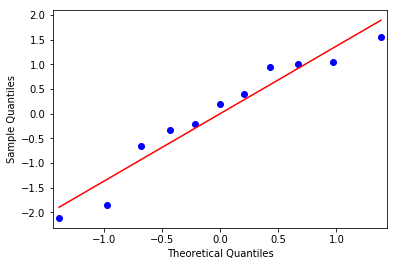

In [291]:
_ = sm.qqplot(res.resid, line='r')

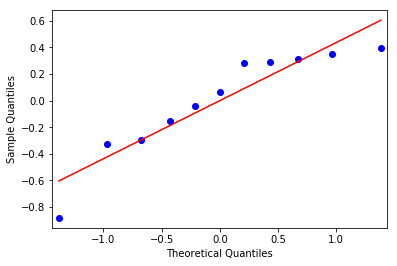

In [292]:
_ = sm.qqplot(res2.resid, line='r')

### OLS Summary Comparison

A comparison of the RegressionResults summary() output shows that the quadratic model does a much better job of explaining the spread of Y2 values (R Squared of 0.962 versus 0.094).   Further, the ```Jarque-Bera``` statistic (a test for normality of the residuals) indicates the the residuals are NOT normally distributed in the linear model, and are probably normally distributed in the quadratic model.

The ```Omnibus``` statistic also indicates that the residuals are not normal in the pure linear case, and probably are normal in the quadratic case.

In [293]:
res.summary()

D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     y2   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     20.15
Date:                Thu, 19 Mar 2020   Prob (F-statistic):            0.00151
Time:                        20:15:36   Log-Likelihood:                -16.975
No. Observations:                  11   AIC:                             37.95
Df Residuals:                       9   BIC:                             38.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7066      1.139      2.377      0.041       0.131       5.282
x2             0.5358      0.119      4.489      0.002       0.266       0.806
==============================================================================
Omnibus:                        1.120   Durbin-Watson:                   2.389
Prob(Omnibus):                  0.571   Jarque-Bera (JB):                0.865
Skew:                          -0.577   Prob(JB):                        0.649
Kurtosis:                       2.255   Cond. No.                         29.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [294]:
res2.summary()

D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     y2   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     115.0
Date:                Thu, 19 Mar 2020   Prob (F-statistic):           1.28e-06
Time:                        20:15:36   Log-Likelihood:                -4.7797
No. Observations:                  11   AIC:                             15.56
Df Residuals:                       8   BIC:                             16.75
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.8860      1.134     -5.189      0.001      -8.502      -3.270
x2             2.7142      0.272      9.961      0.000       2.086       3.342
x2sq          -0.1210      0.015     -8.091      0.000      -0.156      -0.087
==============================================================================
Omnibus:                        4.088   Durbin-Watson:                   3.002
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                1.813
Skew:                          -0.990   Prob(JB):                        0.404
Kurtosis:                       3.195   Cond. No.                         954.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-----
## Heteroscedasticity Tests


### Read and Explore a Medical Dataset

In [295]:
data = pd.read_csv('../data/hiv.txt', sep=' ')

In [296]:
data.head()

,GSS,VL
0,4.0,40406
1,13.4,2603
2,7.4,55246
3,2.7,22257
4,13.5,400


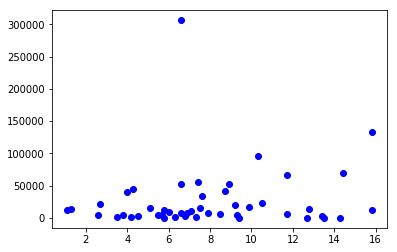

In [297]:
_ = plt.plot(data['GSS'], data['VL'], 'bo')

### Data Cleaning
There is clearly an outlier value, so we exclude it.

In [298]:
data2 = data[data['VL'] < 200_000].copy()

len(data), len(data2)

(47, 46)

### Fit a Linear Model

In [299]:
res = ols('VL ~ GSS', data=data2).fit()

Display the line of best fit

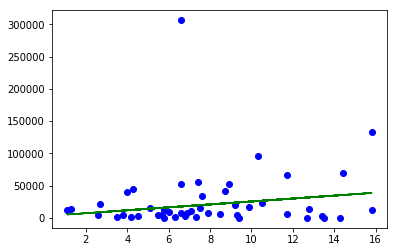

In [300]:
_ = plt.plot(data['GSS'], data['VL'], 'bo')
_ = plt.plot(data2['GSS'], res.predict(), 'g-')

Plotting the residuals indicates the the error variance is NOT constant 

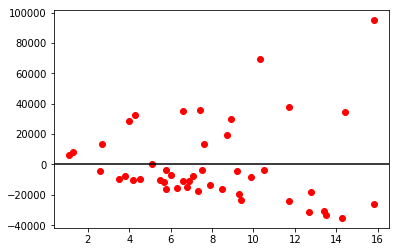

In [301]:
_ = plt.plot(data2['GSS'], res.resid, 'ro')
_ = plt.axhline(0, color='black')

Looking at the ```Jarque-Bera``` statistic in the ```summary()``` output, we seec that there is a vanishingly small chance that the residuals have constant variance

In [302]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     VL   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     4.588
Date:                Thu, 19 Mar 2020   Prob (F-statistic):             0.0378
Time:                        20:15:37   Log-Likelihood:                -533.49
No. Observations:                  46   AIC:                             1071.
Df Residuals:                      44   BIC:                             1075.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2801.5167   9296.119      0.301      0.765   -1.59e+04    2.15e+04
GSS         2270.9411   1060.225      2.142      0.038     134.198    4407.684
==============================================================================
Omnibus:                       20.332   Durbin-Watson:                   2.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.927
Skew:                           1.473   Prob(JB):                     8.63e-07
Kurtosis:                       5.428   Cond. No.                         20.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Additional Heteroscedasticity Tests

```statsmodels```  has a number of tests for constant variance residuals.  These tests not addressed in the lecture (but almost certainly R supports them).  We show the results for two of them below.  They confirm that the residuals are very unlikely to be distributed with constant variance.

In [303]:
x = sm.add_constant(data2['GSS'])
lm, lm_pvalue, fvalue, f_pvalue = het_white(res.resid, x)

In [304]:
print(
    'White Test for Heteroscedasticity\n',
    f'lagrange multiplier statistic. = {lm}, \n lagrange multiplier statistic = {lm_pvalue},\n',
    f'f-statistic of the hypothesis that the error variance does not depend on x = {fvalue}, \n',
    f'p-value for the f-statistic = {f_pvalue}',
)

White Test for Heteroscedasticity
 lagrange multiplier statistic. = 13.406116178729887, 
 lagrange multiplier statistic = 0.0012271534139010932,
 f-statistic of the hypothesis that the error variance does not depend on x = 8.843116071199791, 
 p-value for the f-statistic = 0.0006069222408836576


In [305]:
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(
    res.resid, x
)

In [306]:
print(
    'Breusch-Pagan Test for Heteroscedasticity\n',
    f'lagrange multiplier statistic. = {lm}, \n lagrange multiplier statistic = {lm_pvalue},\n',
    f'f-statistic of the hypothesis that the error variance does not depend on x = {fvalue}, \n',
    f'p-value for the f-statistic = {f_pvalue}',
)

Breusch-Pagan Test for Heteroscedasticity
 lagrange multiplier statistic. = 9.853439236968049, 
 lagrange multiplier statistic = 0.0016951455261255141,
 f-statistic of the hypothesis that the error variance does not depend on x = 11.994262172516247, 
 p-value for the f-statistic = 0.001200741299367376



---------
## Reproducibility

In [307]:
%watermark -h -iv
%watermark

statsmodels 0.9.0
pandas      1.0.0
seaborn     0.9.0
matplotlib  3.0.2
scipy       1.1.0
numpy       1.15.4
host name: DESKTOP-SODFUN6
2020-03-19T20:15:37+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
